<img src="../../assets/maxsqn.png" width=800 />

着实可以理解为soft actor-critic的离散动作版本,但动作sample使用的是Q_network进行softmax操作

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gym
import numpy as np
from torch.distributions import Categorical
%matplotlib inline

In [2]:
class ReplayBuffer:
    def __init__(self, column, batch_size, buffer_size):
        self.current_state = np.zeros((buffer_size, column), dtype=np.float32)
        self.next_state = np.zeros((buffer_size, column), dtype=np.float32)
        init = lambda buffer_size : np.zeros(buffer_size, dtype=np.float32)
        self.action = init(buffer_size)
        self.reward = init(buffer_size)
        self.done = init(buffer_size)
        self.buffer_size, self.batch_size = buffer_size, batch_size
        self.size, self.current_index = 0, 0
    
    def store(self, current_state, action, next_state, reward, done):
        self.current_state[self.current_index] = current_state
        self.action[self.current_index] = action
        self.next_state[self.current_index] = next_state
        self.reward[self.current_index] = reward
        self.done[self.current_index] = done
        self.current_index = (self.current_index + 1) % buffer_size
        self.size = min(self.buffer_size, (self.size + 1))
    
    def sample(self):
        index = np.random.choice(self.size, self.batch_size, replace=False)
        return dict(current_state = torch.tensor(self.current_state[index],dtype=torch.float).to(device),
                    action = torch.tensor(self.action[index],dtype=torch.long).reshape(-1, 1).to(device),
                    next_state = torch.tensor(self.next_state[index],dtype=torch.float).to(device),
                    reward = torch.tensor(self.reward[index]).reshape(-1, 1).to(device),
                    done = torch.tensor(self.done[index]).reshape(-1, 1).to(device))
    
    def __len__(self):
        return self.size

In [3]:
class Q_network(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=300):
        super(Q_network, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, state, alpha):
        x = self.linear1(state)
        x = self.linear2(x)
        value = self.linear3(x)
        
        log_pi = F.softmax(value/alpha, dim=1)
        log_pi = F.softmax(value, dim=1)
        dist = Categorical(log_pi)
        
        return dist, value

In [4]:
# env_name = "LunarLander-v2"
env_name = "CartPole-v0"
env = gym.make(env_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_dim = env.observation_space.shape[0]
out_dim = env.action_space.n

Q_net1 = Q_network(in_dim, out_dim).to(device)
Q_net2 = Q_network(in_dim, out_dim).to(device)
target_Q_net1 = Q_network(in_dim, out_dim).to(device)
target_Q_net2 = Q_network(in_dim, out_dim).to(device)
target_Q_net1.load_state_dict(Q_net1.state_dict())
target_Q_net2.load_state_dict(Q_net2.state_dict())

Q_net1_optimizer = optim.Adam(Q_net1.parameters())
Q_net2_optimizer = optim.Adam(Q_net2.parameters())

train_episodes = 5000
train_steps = 500
start_steps = 100
alpha = 0.15

buffer_size = int(1.5e4)
batch_size = 128
replay_buffer = ReplayBuffer(in_dim, batch_size, buffer_size)

target_entropy = -1.0
log_alpha = torch.zeros(1, requires_grad=True, device=device) # tensor([0.], device='cuda:0', requires_grad=True)
alpha = torch.exp(log_alpha)
alpha_optim = optim.Adam([log_alpha])

In [5]:
def smooth_plot(factor, item, plot_decay):
    item_x = np.arange(len(item))
    item_smooth = [np.mean(item[i:i+factor]) if i > factor else np.mean(item[0:i+1])
                  for i in range(len(item))]
    for i in range(len(item)// plot_decay):
        item_x = item_x[::2]
        item_smooth = item_smooth[::2]
    return item_x, item_smooth
    
def plot(episode, rewards, critic_losses, actor_losses, episode_steps):
    clear_output(True)
    rewards_x, rewards_smooth = smooth_plot(10, rewards, 1000)
    critic_losses_x, critic_losses_smooth = smooth_plot(10, critic_losses, 1000)
    actor_losses_x, actor_losses_smooth = smooth_plot(10, actor_losses, 1000)
    episode_steps_x, episode_steps_smooth = smooth_plot(10, episode_steps, 1000)
    
    plt.figure(figsize=(18, 16))
    plt.subplot(411)
    plt.title('episode %s. Reward: %s'%(episode, rewards_smooth[-1]))
    plt.plot(rewards, label="Rewards", color='lightsteelblue', linewidth='1')
    plt.plot(rewards_x, rewards_smooth, label='Smothed_Rewards', color='darkorange', linewidth='3')
    plt.legend(loc='best')
    
    plt.subplot(412)
    plt.title('Q_net1_losses') #%s. Losses: %s'%(episode, critic_losses_smooth[-1]))
    plt.plot(critic_losses,label="Q_net1_losses",color='lightsteelblue',linewidth='1')
    plt.plot(critic_losses_x, critic_losses_smooth, 
             label="Smoothed_Q_net1_losses",color='darkorange',linewidth='3')
    plt.legend(loc='best')
    
    plt.subplot(413)
    plt.title('Alpha_losses') #%s. Losses: %s'%(episode, actor_losses_smooth[-1]))
    plt.plot(actor_losses,label="Alpha_losses",color='lightsteelblue',linewidth='1')
    plt.plot(actor_losses_x, actor_losses_smooth, 
             label="Smoothed_Alpha_losses",color='darkorange',linewidth='3')
    plt.legend(loc='best')
    
    plt.subplot(414)
    plt.title('Episode_Steps %s. Steps: %s'%(episode, episode_steps_smooth[-1]))
    plt.plot(episode_steps,label="Episode_Steps",color='lightsteelblue',linewidth='1')
    plt.plot(episode_steps_x, episode_steps_smooth, 
             label="Episode_Steps_Losses",color='darkorange',linewidth='3')
    plt.legend(loc='best')
    
    plt.show()

In [6]:
def sqn_train(gamma=0.99, soft_tau=5e-3):
    global alpha, Q_net1, Q_net2, target_Q_net1, target_Q_net2
    samples = replay_buffer.sample()
    state, action, next_state = samples['current_state'], samples['action'], samples['next_state']
    reward, done = samples['reward'], samples['done']
    
    with torch.no_grad():
        target_dist_1, target_value_1 = target_Q_net1(next_state, alpha)
        entropy_1 = target_dist_1.entropy().unsqueeze(1)
        _, target_value_2 = target_Q_net2(next_state, alpha)
        target_value = torch.min(
                            torch.max(target_value_1, dim=1, keepdim=True)[0],
                            torch.max(target_value_2, dim=1, keepdim=True)[0]
                        )
        target_dist, _ = Q_net1(next_state, alpha)
        target_entropy_1 = target_dist.entropy().unsqueeze(1)
        target_Q = reward + gamma * (1-done) * (target_value - alpha * target_entropy_1)
    
    _, value1 = Q_net1(state, alpha)
    _, value2 = Q_net2(state, alpha)
    Q_value_1 = torch.gather(value1, 1, action)
    Q_value_2 = torch.gather(value2, 1, action)
    
    Q_loss_1 = F.mse_loss(target_Q, Q_value_1)
    Q_loss_2 = F.mse_loss(target_Q, Q_value_2)
    
    Q_net1_optimizer.zero_grad()
    Q_loss_1.backward()
    Q_net1_optimizer.step()
    
    Q_net2_optimizer.zero_grad()
    Q_loss_2.backward()
    Q_net2_optimizer.step()
    
    alpha_loss = - log_alpha * (entropy_1 + target_entropy).mean()

    alpha_optim.zero_grad()
    alpha_loss.backward()
    alpha_optim.step()

    alpha = log_alpha.exp()
    
    for target_param, param in zip(target_Q_net1.parameters(), Q_net1.parameters()):
        target_param.data.copy_(target_param.data*(1.0-soft_tau) + param.data*soft_tau)
    for target_param, param in zip(target_Q_net2.parameters(), Q_net2.parameters()):
        target_param.data.copy_(target_param.data*(1.0-soft_tau) + param.data*soft_tau)
    
    return Q_loss_1.item() , alpha_loss.item()

In [7]:
def get_action(totoal_steps, state):
    global Q_net1
    if totoal_steps < start_steps:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            dist, _ = Q_net1(state, alpha)
            action = dist.sample().item()
    return action

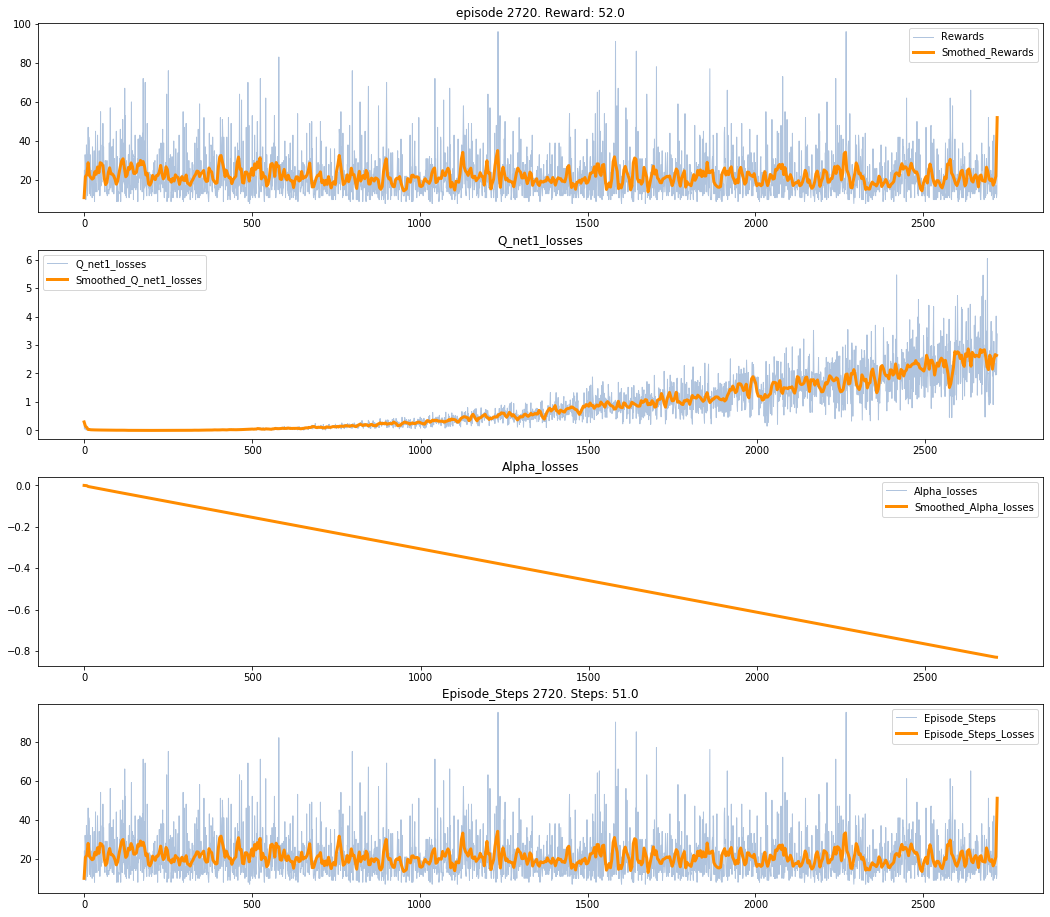

tensor([0.0667], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0667], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0666], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0665], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0665], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0664], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0663], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0663], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0662], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0661], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0661], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0660], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0660], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0659], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0658], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0658], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0657], device='cuda:0', grad_fn=<ExpBackward>)
tensor([0.0656], device='cuda:0

KeyboardInterrupt: 

In [8]:
Q_net1_losses, alpha_losses, all_rewards, episode_steps = [], [], [], []
totoal_steps = 0

for episode in range(train_episodes):
    state = env.reset()
    episode_reward = 0
    for i in range(train_steps):
        totoal_steps += 1
        action = get_action(totoal_steps, state)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.store(state, action, next_state, reward, done)      
        state = next_state
        episode_reward += reward
        if done or i==(train_steps-1):
            if len(replay_buffer) > batch_size:
                critic_loss, alpha_loss = sqn_train()
                Q_net1_losses.append(critic_loss)
                alpha_losses.append(alpha_loss)
            episode_steps.append(i)
            break
    
    all_rewards.append(episode_reward)
    if episode % 20 == 0:
        plot(episode, all_rewards, Q_net1_losses, alpha_losses, episode_steps)
    print(alpha)